<a href="https://colab.research.google.com/github/ramonlsaraiva/cuda_tests/blob/main/arithmetic_intensity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/canesche/nvcc4jupyter.git
!git clone https://github.com/canesche/nvcc4jupyter

%load_ext nvcc_plugin
!nvidia-smi

  Cloning https://github.com/canesche/nvcc4jupyter.git to /tmp/pip-req-build-bswyy84w
  Running command git clone -q https://github.com/canesche/nvcc4jupyter.git /tmp/pip-req-build-bswyy84w
  Created wheel for ColabPlugin: filename=ColabPlugin-blind-py3-none-any.whl size=12727 sha256=f67ae1867a4427f14268c4f16e0504b778d62d18319a242d7ac98ff47e7bed0e
  Stored in directory: /tmp/pip-ephem-wheel-cache-y2vlg2b4/wheels/06/76/5f/88825d3256ab9fe9e4386e23ad33a2c41a2e4dc94f0addff44
Failed to build ColabPlugin
    Running setup.py install for ColabPlugin ... done
  DEPRECATION: ColabPlugin was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.
Cloning into 'nvcc4jupyter'...
remote: Enumerating objects: 1147, done.
remote: Counting objects: 100% (362/362), done.
remote: Compressing objects: 100% (271/2

In [3]:
#@title ### **Gerando o código CUDA**<br> 
#@markdown Este script em python irá gerar o código CUDA a ser testado na GPU. <br>
#@markdown Determine:
#@markdown * A intensidade inicial
#@markdown * A intensidade final
#@markdown * O passo das intensidades a serem testadas
#@markdown * O número de testes a serem realizados para cada kernel
#@markdown * O tipo de dado a ser testado


import numpy

while True:
  intensidadeInicial = float(input("Intensidade Inicial: "))
  if intensidadeInicial%0.5==0:
    break
  print("Digite um número múltiplo de 0.5!\n")

while True:
  intensidadeFinal = float(input("Intensidade Final: "))
  if intensidadeFinal%0.5==0:
    break
  print("Digite um número múltiplo de 0.5!\n")

while True:
  passo = float(input("Passo da Intensidade: "))
  if passo%0.5==0:
    break
  print("Digite um número múltiplo de 0.5!\n")

while True:
  nTestes = input("Número de Testes: ")
  try:
    int(nTestes)
    break
  except:
    print("Digite um número inteiro!\n")

tipo = input("Tipo de Dado: ").lower()


objOpen = open("arithmetic_intensity.cu", "w")

codigo0 = """#define N 1024*1024*16

"""

k=0
codigo1=''
for i in numpy.arange(intensidadeInicial,intensidadeFinal+passo,passo):
	codigo1=codigo1+"#define EQ"+str(k)+" C[idx]=A[idx]"
	for j in numpy.arange(0,2*i):
		if j%2==0:
			codigo1=codigo1+"+B[idx]"
		else:
			codigo1=codigo1+"+A[idx]"
	codigo1=codigo1+"\n"
	k+=1

codigo2 = "float intensity[] = {"
for i in numpy.arange(intensidadeInicial,intensidadeFinal+passo,passo):
	codigo2 = codigo2+str(i)+","
codigo2=codigo2[:-1]+"};\n"


codigo3 = """
#include <stdio.h>
#include <stdlib.h>

#include "cuda_runtime.h"
#include "device_launch_parameters.h"

void fill_array("""+tipo+""" *data) {
	for(int idx=0;idx<N;idx++)
		data[idx] = idx;
}


int verify_output("""+tipo+" *A, "+tipo+" *B, "+tipo+""" *C, int k) {
	int ok = 1;
"""	

codigo4=''
for k in numpy.arange(len(numpy.arange(intensidadeInicial,intensidadeFinal+passo,passo))):
	codigo4 = codigo4 + """
		if (k=="""+str(k)+""")
			for (int idx=0;idx<N;idx++)
		    	if (EQ"""+str(k)+""" != C[idx]) ok = 0;

"""

codigo5 = """
	return ok;
}

"""

codigo6=''
for k in numpy.arange(len(numpy.arange(intensidadeInicial,intensidadeFinal+passo,passo))):
	codigo6 = codigo6 + """
__global__ void funcEQ"""+str(k)+"("+tipo+" *A, "+tipo+" *B,"+tipo+""" *C){
	int idx = threadIdx.x + blockIdx.x * blockDim.x;
    if (idx<N) EQ"""+str(k)+""";
}

"""

codigo7 = """
int main(){
	
	FILE *pFile;
	pFile = fopen("valores.txt", "w"); 

	"""+tipo+""" *A = ("""+tipo+"""*) malloc(N*sizeof("""+tipo+"""));
	"""+tipo+""" *B = ("""+tipo+"""*) malloc(N*sizeof("""+tipo+"""));
	"""+tipo+""" *C = ("""+tipo+"""*) malloc(N*sizeof("""+tipo+"""));

	fill_array(A);
	fill_array(B);

	"""+tipo+""" *dA, *dB, *dC;

	cudaMalloc(&dA, N*sizeof("""+tipo+"""));
	cudaMalloc(&dB, N*sizeof("""+tipo+"""));
	cudaMalloc(&dC, N*sizeof("""+tipo+"""));

	
	for(int i=0; i<(sizeof intensity/sizeof (float)); i++){
		dim3 nThreads = 1024;
		dim3 nBlocks = (N+nThreads.x-1)/nThreads.x;

		float timeKernel;
		cudaEvent_t startKernel, endKernel; 
		cudaEventCreate(&startKernel);
		cudaEventCreate(&endKernel);

		cudaMemcpy(dA, A, N*sizeof("""+tipo+"""), cudaMemcpyHostToDevice);
		cudaMemcpy(dB, B, N*sizeof("""+tipo+"""), cudaMemcpyHostToDevice);

		float averageKernel = 0;
		for (int j=1; j<="""+nTestes+"""; j++){
"""	

codigo8=''
for k in numpy.arange(len(numpy.arange(intensidadeInicial,intensidadeFinal+passo,passo))):
	codigo8 = codigo8 + """
		if (i=="""+str(k)+"""){
			cudaEventRecord(startKernel);
			funcEQ"""+str(k)+""" <<< nBlocks, nThreads >>> (dA, dB, dC);
			cudaEventRecord(endKernel);
			cudaEventSynchronize(endKernel);
			cudaEventElapsedTime(&timeKernel, startKernel, endKernel);
		}

"""

		
codigo9 = """		
			cudaMemcpy(C, dC, N*sizeof("""+tipo+"""), cudaMemcpyDeviceToHost);

			if (verify_output(A,B,C,i)){
				printf("Soma correta!\\n");
				averageKernel = (averageKernel*(j-1)+timeKernel)/j;
			}
			else {
				printf("*** SOMA ERRADA! ***\\n");
				j=j-1;
			}
		
		}

		float gopsKernel = N*intensity[i]*2/(averageKernel*1000000);
		
		printf("Intensidade: %f\\nGops/s: %f\\nTempo Kernel: %f ms\\n\\n\\n",intensity[i],gopsKernel,averageKernel);
		fprintf(pFile, "%f;%f\\n", intensity[i], gopsKernel);

	}

	fclose(pFile);
	free(A);
	free(B);
	free(C);
	cudaFree(dA);
	cudaFree(dB);
	cudaFree(dC);


	pFile = fopen("modeloGPU.txt", "w"); 
	
	cudaDeviceProp varProp;
	cudaGetDeviceProperties(&varProp,0);
	fprintf(pFile, "%s", varProp.name);
	fclose(pFile);


	return 0;
}


"""


objOpen.write(codigo0+codigo1+codigo2+codigo3+codigo4+codigo5+codigo6+codigo7+codigo8+codigo9)


objOpen.close()

Intensidade Inicial: 10
Intensidade Final: 40
Passo da Intensidade: 5
Número de Testes: 5
Tipo de Dado: Double


Rodando o código CUDA gerado:

In [4]:
%%gpu

#include "arithmetic_intensity.cu"


Soma correta!
Soma correta!
Soma correta!
Soma correta!
Soma correta!
Intensidade: 10.000000
Gops/s: 109.545029
Tempo Kernel: 3.063072 ms


Soma correta!
Soma correta!
Soma correta!
Soma correta!
Soma correta!
Intensidade: 15.000000
Gops/s: 161.974579
Tempo Kernel: 3.107379 ms


Soma correta!
Soma correta!
Soma correta!
Soma correta!
Soma correta!
Intensidade: 20.000000
Gops/s: 208.688873
Tempo Kernel: 3.215738 ms


Soma correta!
Soma correta!
Soma correta!
Soma correta!
Soma correta!
Intensidade: 25.000000
Gops/s: 249.898483
Tempo Kernel: 3.356806 ms


Soma correta!
Soma correta!
Soma correta!
Soma correta!
Soma correta!
Intensidade: 30.000000
Gops/s: 282.272858
Tempo Kernel: 3.566170 ms


Soma correta!
Soma correta!
Soma correta!
Soma correta!
Soma correta!
Intensidade: 35.000000
Gops/s: 307.284515
Tempo Kernel: 3.821882 ms


Soma correta!
Soma correta!
Soma correta!
Soma correta!
Soma correta!
Intensidade: 40.000000
Gops/s: 324.958008
Tempo Kernel: 4.130310 ms





Gerando os gráficos de Gops/s x Intensidade

No handles with labels found to put in legend.


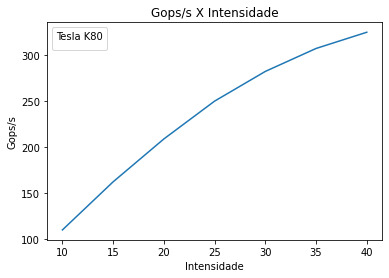

In [11]:
#@title ### **Gerando o gráfico de Gops/s x Intensidade**<br> 

from matplotlib import pyplot

objOpen = open("modeloGPU.txt","r")
modelo = objOpen.read()
objOpen.close()

objOpen = open("valores.txt","r")
valores = objOpen.read()
objOpen.close()
valores = valores.split("\n")
valores = [varFor.split(";") for varFor in valores if varFor!='']

intensity = [float(varFor[0]) for varFor in valores]
gopsKernel = [float(varFor[1]) for varFor in valores]


pyplot.title("Gops/s X Intensidade")
pyplot.xlabel("Intensidade")
pyplot.ylabel("Gops/s")
pyplot.legend(title=modelo)
pyplot.plot(intensity, gopsKernel)
pyplot.show()
